# Filtered ICA on 1D Fields

zeta multiplication factor = { (2*\pi*sidelength)/(sidelength_in_mpc) }^3

peak-patch/tools/powerspectrum_create

pkp tables/planck18_intermittent.dat
(1st column -- k; 2nd -- delta_delta power spectrum; 3rd -- zeta transfer func/k^2)
zeta power spectrum = 2nd col / 3rd^2

tables/plot_spectra.py line 142

zeta = zeta(g)

take flat GRF power spectrum, multiply by sqrt[ (2*\pi*N / N_in_Mpc)^3 {power spectra above} ].

will have real-space zeta(x) = zeta_g + fnl*chi^2

<b>Import modules</b>

In [1]:
%load_ext autoreload

In [2]:
import importlib as il
import copy

from pathlib import Path # For path manipulations and module loading
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 12})
import matplotlib.gridspec as grd
import pickle

import scipy.interpolate as interpolate
import scipy.signal as signal
import scipy.stats as stats

# Independent Component Analysis
# sklearn module contains contains a FastICA capability. We can chose the cost function (measure of non-Gaussianity): 
# cube for kurtosis and logcosh for negentropy approximation.
from sklearn.decomposition import FastICA

import modules.peaks as px
import modules.fouriertransform as ft
import modules.correlationfunctions as cf
import modules.gaussianfield as grf
import modules.filters as flt

<b>Set parameters and initialize GRFs</b>

In [3]:
# Parameters
logtwo_N = 20
N = 2**logtwo_N
BoxSize = 512.0
dx = BoxSize/N
h = 0.695
k0 = 0.02 
A0 = (7.96*10**-10)# * 2*np.pi**2)
ns = 0.965
seed = 50
dk = (2*np.pi) / BoxSize # Bin size (for power spectrum)
Pk = lambda k: A0*(k/k0)**(ns-1)*k**-3

# Other NG parameters
alpha = 1.0
nu = 2
c, w = 2, .2

# Generate the grfs using gaussianfield
zg = grf.gaussian_random_field_1D(N, BoxSize=N, seed=seed)
zf = grf.gaussian_random_field_1D(N, BoxSize=N, seed=10000)

size = zg.size

## Generate nonG fields

In [4]:
# Generate nonG fields

# Extract the standard deviation of the gaussian fields
s = zg.std()
sf = zf.std()

# Generate the non-gaussian components that will be added to the gaussian fields
NG_symsinh = px.map_sinh(zg, nu*s, alpha) - zg
NG_asymsinh = px.map_asymm_sinh(zg, nu*s, alpha) - zg
NG_smooth_bump = px.map_smooth_bump(zg, c, w) - zg
NG_squared = zg**2 - zg

# Generate the correlated NG zeta fields 
# Note that 'g' is the field used to generate the NG component called 'NG_asymsinh'. 
# So the 'NG_asymsinh' is correlated with 'g' but uncorrelated with 'f', a different Gaussian random field.
# The total fields are named accordingly (with or without suffix '_uncorr').
zng_symsinh = zg + NG_symsinh
zng_asymsinh = zg + NG_asymsinh
zng_smooth_bump = zg + NG_smooth_bump
zng_squared = zg + zg**2

# Generate the uncorrelated NG zeta fields 
zng_symsinh_uncorr = zf + NG_symsinh
zng_asymsinh_uncorr = zf + NG_asymsinh
zng_smooth_bump_uncorr = zf + NG_smooth_bump
zng_squared_uncorr = zf + zg**2

# Test the asymmetric sinh function applied to a linear function tf
tf = np.linspace(-4, 4, N)
zng_asymsinh_test = px.map_asymm_sinh(tf, nu*s, alpha) - tf

zng = NG_asymsinh
z = zng_asymsinh
z_un = zng_asymsinh_uncorr
# Generate gaussian distribution from mean and std of NG zeta fields
# ???

## Why are we getting an error for invalid value in power?

In [5]:
correlated = True

## <u>Apply Filtered ICA to 1D fields</u>
<b> For fully determined ICA separation.
<br>
Sklearn's implementation does not allow for underdetermined separation. </b>

### Setup

In [ ]:
# Top hat bands
def window(g, N, k_low, k_up):
    """
    
    """
    
    x = np.fft.rfft(g)
    # print(x[0:10])

    k = np.fft.rfftfreq(N) * N
    # print(k[0:10])

    # print(k[:N//2])

    k_low = np.ones(np.shape(x))*k_low
    k_up = np.ones(np.shape(x))*k_up

    x = np.where(np.logical_and(np.less_equal(k, k_up), np.greater(k, k_low)), x, 0)
    x_inv = np.fft.irfft(x)

    return x_inv

def filter(g_field, ng_field, size, k_low, k_high):
    """
    
    """

    g_field = window(g_field, size, k_low, k_high)
    ng_field = window(ng_field, size, k_low, k_high)

    return [g_field, ng_field]


In [ ]:
def ica_setup(source_noise, source_nonG):
    """
    source_noise    :   grf generated using gaussianfield [in Notebook Setup above]
    source_nonG     :   returns n columns corresponding to n gaussian peaks that are shifted by xPeak/xc relative to 0 (and scaled by the size of the field)

    source_comps    :   array of source component arrays
    num_comps       :   num of different source signals/components, i.e. GRF & no. of peaks
    num_samples     :   num of observations (has to be >= num_comps)
    mix_matrix      :   mixing matrix generated randomly with entries over [0.5, 1)
    mix_signal      :   resulting mixed/observed signals (not prewhitened)
    """

    # source_noise = g # Gaussian random noise
    # source_nonG = zng

    source_comps = np.vstack([source_nonG, source_noise]) 
    num_comps = source_comps.shape[0]
    num_samples = num_comps

    mix_matrix = (1+np.random.random((num_samples, num_comps)))/2.0 
    mix_signal = np.dot(mix_matrix, source_comps) # mixed signals

    return mix_signal, source_comps, num_comps

def ica_run(mix, num_comps, max_iter=1e4, tol=1e-15, 
        fun='logcosh', algo='parallel', white='unit-variance'):
    """Initialize FastICA with given params.

    Notes:
            Logcosh is negentropy.
    """
    
    transformer = FastICA(n_components=num_comps, algorithm=algo, whiten=white, max_iter=max_iter, tol=tol, fun=fun)

    # run FastICA on observed (mixed) signals
    sources = transformer.fit_transform(mix.T) # run FastICA on observed signals

    return sources.T

def ica_swap(source_comps, ica_src):
    """
    
    """
    
    # print('\nBeginning swap...')
    ica_sources = np.ndarray.copy(ica_src)

    srcng = source_comps[0, :]
    srcg = source_comps[1, :]
    ica0 = ica_sources[0, :]
    ica1 = ica_sources[1, :]

    dist_ng0 = np.linalg.norm(srcng**2 - ica0**2, 1)
    dist_ng1 = np.linalg.norm(srcng**2 - ica1**2, 1)
    dist_g0 = np.linalg.norm(srcg**2 - ica0**2, 1)
    dist_g1 = np.linalg.norm(srcg**2 - ica1**2, 1)
    print('dist nong->ica1:', dist_ng1, ' | dist nong->ica0:', dist_ng0)
    print('dist g->ica0:', dist_g0, ' | dist g->ica1:', dist_g1)
    if dist_ng0 > dist_ng1:
        print('dist nong->ica1:', dist_ng1, ' | dist nong->ica0:', dist_ng0)
        print('dist g->ica0:', dist_g0, ' | dist g->ica1:', dist_g1)
        ica_sources = np.flip(ica_sources, 0)
        print('Swapped!')

    icang, icag = ica_sources[0, :], ica_sources[1, :]

    # print('...ending swap.\n')
    return ica_sources

def ica_signflip(source_comps, ica_src):
    """
    
    """
    
    # print('\nBeginning flip...')
    ica_sources = np.ndarray.copy(ica_src)

    srcng = source_comps[0, :]
    srcg = source_comps[1, :]
    icang = ica_sources[0, :]
    icag = ica_sources[1, :]

    dist_gg = np.linalg.norm(srcg - icag, 1)
    dist_neg_gg = np.linalg.norm(srcg + icag, 1)
    dist_ngng = np.linalg.norm(srcng - icang, 1)
    dist_neg_ngng = np.linalg.norm(srcng + icang, 1)
    
    if dist_gg > dist_neg_gg:
        # print('dist_gg:', dist_gg, ' | dist_neg_gg:', dist_neg_gg)
        icag = -icag
        print('Gauss sign flipped!')

    if dist_ngng > dist_neg_ngng:
        # print('dist_ngng:', dist_ngng, ' | dist_neg_ngng:', dist_neg_ngng)
        icang = -icang
        print('NonG sign flipped!')

    ica_sources[0, :], ica_sources[1, :] = icang, icag
    
    # print('...ending flip.\n')
    return ica_sources

def ica_scale(source_comps, ica_src):
    """
    
    """

    ica_sources = np.ndarray.copy(ica_src)

    src_ng_max = np.abs(source_comps[0]).max()
    src_g_max = np.abs(source_comps[1]).max()
    src_max = np.abs(source_comps).max()
    ica_ng_max = np.abs(ica_sources[0]).max()
    ica_g_max = np.abs(ica_sources[1]).max()
    ica_max = np.abs(ica_sources).max()
    
    ng = ica_sources[0, :]
    ng = ng * ( src_ng_max / ica_ng_max )
    g = ica_sources[1, :]
    g = g * ( src_g_max / ica_g_max )
    ica_sources[0, :] = ng; ica_sources[1, :] = g

    ica_ng_max = np.abs(ng).max()
    ica_g_max = np.abs(g).max()
    ica_max = np.abs(ica_sources).max()

    return ica_sources, [src_max, src_ng_max, src_g_max], [ica_max, ica_ng_max, ica_g_max]

def ica_prepres(source_comps, ica_src):
    """
    
    """

    ica_sources = np.ndarray.copy(ica_src)

    ica_sources = ica_swap(source_comps, ica_sources)
    ica_sources = ica_signflip(source_comps, ica_sources)
    ica_sources, src_max, ica_max = ica_scale(source_comps, ica_sources)

    return ica_sources, src_max, ica_max

In [1]:
#
#
# ICA parameters/vars
#
#
max_iter = int(9e13)
tol = 1e-12

#
#
# Run ICA
#
#
mix_signal, source_comps, num_comps = ica_setup(zg, zng)
ica_src_og = ica_run(mix_signal, num_comps, max_iter, tol)

# #--------------------------------------------------#

# ica_srcs = ica_swap(source_comps, ica_src_og)
# ica_srcf = ica_signflip(source_comps, ica_srcs)
# ica_src, src_max, ica_max = ica_scale(source_comps, ica_srcf)
ica_src, src_max, ica_max = ica_prepres(source_comps, ica_src_og)

plt.plot(ica_src_og[0, :], label='og ica0'); plt.plot(ica_src_og[1, :], label='og ica1'); plt.legend(); plt.show()
plt.plot(source_comps[1, :], label='src nong'); plt.plot(ica_src[1, :], label='ica nong'); plt.legend(); plt.show()
plt.plot(source_comps[0, :], label='src gauss'); plt.plot(ica_src[0, :], label='ica gauss'); plt.legend(); plt.show()

NameError: name 'ica_setup' is not defined

### Preprocess the fields

In [6]:
# """
# Handling the two observed signals separately. 
# Preprocessing involves mean subtraction and dividing by the variance (in k-space).
# """

# # Sample 1
# sample1_pre = mix_signal_pre[0, :]
# m1 = np.mean(sample1_pre)
# sample1_ms = sample1_pre - m1 #Subtracting the mean

# sample1_ft = np.fft.fft(sample1_ms)
# sample1_sqrtpower = np.absolute(sample1_ft) #k-space variance

# sample1_ms_white_ft = sample1_ft / sample1_sqrtpower * (size**(1/2)) #Whitening the field

# sample1 = np.fft.ifft(sample1_ms_white_ft).real

# # Sample 2 - same procedure as above
# sample2_pre = mix_signal_pre[1, :]
# m2 = np.mean(sample2_pre)
# sample2_ms = sample2_pre - m2

# sample2_ft = np.fft.fft(sample2_ms)
# sample2_sqrtpower = np.absolute(sample2_ft)

# sample2_ms_white_ft = sample2_ft / sample2_sqrtpower * (size**(1/2))

# sample2 = np.fft.ifft(sample2_ms_white_ft).real

# # Gaussian - same procedure as above
# mg = np.mean(source_g)
# gauss_ms = source_g - mg

# gauss_ft = np.fft.fft(gauss_ms)
# gauss_sqrtpower = np.absolute(gauss_ft)

# gauss_ms_white_ft = gauss_ft / gauss_sqrtpower * (size**(1/2))

# gauss_white = np.fft.ifft(gauss_ms_white_ft).real

# # Mix the samples back again
# mix_signal = np.vstack([sample1, sample2])

# # plt.figure(figsize=(18,5))
# # plt.plot(sample1)

# # plt.figure(figsize=(18,5))
# # plt.plot(sample2)

NameError: name 'mix_signal_pre' is not defined

### Plot the sources

In [ ]:
"""
Unprocessed source components
"""

if correlated:
    k = 'G1'
    t = 'Correlated'
else:
    k = 'G2'
    t = 'Uncorrelated'
    
plt.figure(figsize=(18,12))
plt.suptitle(r'Unprocessed Source Components ({0} NG Case)'.format(t))

plt.subplot(221)
plt.plot(source_g)
plt.title(r'$\zeta_{{{0}}}$'.format(k))
plt.xlabel(r'$x$')
plt.ylabel("Amplitude")

plt.subplot(222)
plt.plot(source_ng, color='C1')
plt.title(r'$\zeta_{NG}$')
plt.xlabel(r'$x$')
plt.ylabel("Amplitude")

plt.subplot(223)
plt.plot(source_ng + source_g, color='C2')
plt.title(r'$\zeta_{{{0}}}+\zeta_{{NG}}$'.format(k))
plt.xlabel(r'$x$')
plt.ylabel("Amplitude")

# if correlated:
#     plt.savefig('ICA_corr_sources.png')
# else:
#     plt.savefig('ICA_uncorr_sources.png')

In [ ]:
"""
Same plots as above
"""

if correlated:
    k = 'G1'
    t = 'Correlated'
else:
    k = 'G2'
    t = 'Uncorrelated'

# ax1.plot(source_g)
# ax1.set_title(r'$\zeta_{{{0}}}$'.format(k))

# ax2.plot(source_ng, color='C1')
# ax2.set_title(r'$\zeta_{NG}$')

# ax3.plot(source_ng + source_g, color='C2')
# ax3.set_title(r'$\zeta_{{{0}}}+\zeta_{{NG}}$'.format(k))

fig, ax = plt.subplots(3, 1,  sharex=True, sharey=True, figsize=(14,20))

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel("Amplitude")
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
# Original NG component
ax[0].plot(source_g)
ax[1].plot(source_ng, color='C1')
ax[2].plot(source_ng + source_g, color='C2')
ax[2].xaxis.set_tick_params(labelbottom=True)
plt.xlabel(r'$x$')

fig.tight_layout()
fig.subplots_adjust(hspace=0)

plt.text(0.94, 0.95, r'$\zeta_{{{0}}}$'.format(k), fontsize=30, horizontalalignment='right')
plt.text(0.94, 0.62, r'$\zeta_{NG_1}$', fontsize=30, horizontalalignment='right')
plt.text(0.94, 0.28, r'$\zeta_{{{0}}}+\zeta_{{NG_1}}$'.format(k), fontsize=30, horizontalalignment='right')

# if correlated:
#     plt.savefig('ICA_corr_sources.png')
# else:
#     plt.savefig('ICA_uncorr_sources.png')

### Apply Sklearn's $\texttt{FastICA}$

In [ ]:
"""Filtering.

"""

#
#
# Filtering parameters/vars
#
#
nbins = 3
k_size = size//2 + 1
k_low = 0
k_high = 10
kc = np.linspace(0, k_high, nbins+1)
# kc = np.array([0, 20, 40, 80])
kc_size = kc.size

#
#
# ICA parameters/vars
#
#
max_iter = int(9e8)
tol = 1e-11
ica_src = np.zeros((kc_size+1, 2, size))

#
#
# Run ICA
#
#
mix_signal, src, num_comps = ica_setup(zg, zng)
ica_src_og = ica_run(mix_signal, num_comps, max_iter, tol)
ica_src[0, :], src_max, ica_max = ica_prepres(src, ica_src_og)


#
#
# Plot
#
#
plt.rcParams.update({'font.size': 7})
nrows = nbins + 1
ncols = 2

fig, ax = plt.subplots(nrows, ncols, sharex='all', figsize=(6*ncols, 3*nrows), constrained_layout=True)

offset = src_max[0]*1.8
offset_ica = ica_max[0]*1.8

# Plotting source components
ax[0, 0].set_title("(a) Source Components")
ax[0, 0].set(ylabel="Zeta amplitude without filtering.")
for j in range(num_comps):
    if j == 0:
        label = "Non-Gaussian Component"
    else:
        label = "Gaussian Component"
    ax[0, 0].plot(src[j, :] + offset*j, label=label)

# Plotting ICA-separated signals
ax[0, 1].set_title("(b) ICA-Separated Signals")
for j in range(num_comps):
    if j == 0:
        label = "Non-Gaussian Component"
    else:
        label = "Gaussian Component"
    ax[0, 1].plot(ica_src[0, j, :] + offset_ica*j, label=label) # Amplitudes are scaled arbitrarily because ICA doesn't recover amp

ax[0, 0].text(0.5, 0.5, "UNFILTERED - FULL FIELD", 
                fontsize='xx-large', transform=ax[0, 0].transAxes, 
                    ha='center', va='center', alpha=0.4)
ax[0, 1].text(0.5, 0.5, "UNFILTERED - FULL FIELD", 
                fontsize='xx-large', transform=ax[0, 1].transAxes, 
                    ha='center', va='center', alpha=0.4)


for i in range(kc_size-1):
    count = i+1
    klow = kc[i]
    khigh = kc[i+1]

    print(f"\nProcessing k-bin number:    {count} ...")

    #
    #
    # Filter
    #
    #
    filtered = filter(zg, zng, size, int(klow), int(khigh))
    zgf, zngf = filtered[0], filtered[1]
    
    #
    #
    # Run ICA
    #
    #
    mix_signal, src, num_comps = ica_setup(zgf, zngf)
    ica_src_og = ica_run(mix_signal, num_comps, max_iter, tol)
    ica_src[count, :], src_max, ica_max = ica_prepres(src, ica_src_og)

    offset = src_max[0]*1.8
    offset_ica = ica_max[0]*1.8


    # Plotting source components
    ax[count, 0].set(ylabel=f'{i+1}) ' + "Zeta Amplitude with filter: " + r"$k=[{{{kl}}}, {{{kh}}}]$".format(kl=klow, kh=khigh))
    for j in range(num_comps):
        if j == 0:
            label = "Non-Gaussian Component"
        else:
            label = "Gaussian Component"
        ax[count, 0].plot(src[j, :] + offset*j, label=label)

    # Plotting ICA-separated signals
    for j in range(num_comps):
        if j == 0:
            label = "Non-Gaussian Component"
        else:
            label = "Gaussian Component"
        ax[count, 1].plot(ica_src[count, j, :] + offset_ica*j, label=label) # Amplitudes are scaled arbitrarily because ICA doesn't recover amp
    
    ax[count, 0].text(0.5, 0.5, r"$k=[{{{kl}}}, {{{kh}}}]$".format(kl=klow, kh=khigh), 
                            fontsize='xx-large', transform=ax[count, 0].transAxes, 
                                ha='center', va='center', alpha=0.4)
    ax[count, 1].text(0.5, 0.5, r"$k=[{{{kl}}}, {{{kh}}}]$".format(kl=klow, kh=khigh), 
                            fontsize='xx-large', transform=ax[count, 1].transAxes, 
                                ha='center', va='center', alpha=0.4)


ax_count = kc_size-1
ax[ax_count, 0].set(xlabel=r'$x$')
ax[ax_count, 1].set(xlabel=r'$x$')

plt.legend()

fig.suptitle(rf'Filtered $\it{{FastICA}}$-separation with $k: [{{{k_low}}}, {{{k_high}}}]$.' + f'\nField size: {size}.', fontsize=16)
plt.show()

(784, 387, range(0, 896))


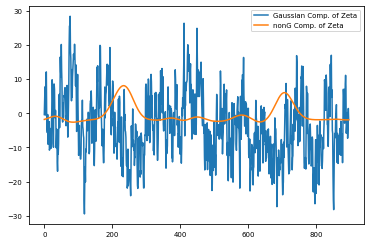

In [31]:

factor = int(1e10)




# with open('crnt_seed.pickle', 'rb') as f:
#     crnt_seed = pickle.load(f)

#--------------------------------------------------#

### Plot 1D Zeta fields

# plt.plot(z, label='Total Zeta')
plt.plot(zg, label='Gaussian Comp. of Zeta')
plt.plot(zng, label='nonG Comp. of Zeta')

plt.legend()